# Limpieza de texto
### Creación de los dataframe y limpieza de texto

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)

In [2]:
import re
def general(txt: str, bert=False, nums=True) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))
        txt = re.sub(r'[^\w\s]', '', txt)

    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt

# Eliminación de expedientes que no son pericias médicas.

In [3]:
# Elimino expedientes que no son pericuas medicas
noPericiasMedicas=[]
for i,expediente in enumerate(df1):
    exp = general(expediente)
    if len(exp.split()) < 300:
        totalPalabras = len(exp.split())
        noPericiasMedicas.append((i, expediente, totalPalabras))
        df1 = df1.drop(i)

dfNoPericiasMedicas = pd.DataFrame(noPericiasMedicas,columns=['id','expediente', 'total de palabras'])

In [5]:
df1.reset_index(drop=True, inplace=True)

In [9]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador horizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [10]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [11]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+[S\n\.]+', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

In [12]:
# limpiar titulos
def limpiar_palabras(text):
    text = re.sub(r'(I{1,3}|IV|V|VI{1,4}|IX|X)[). -]|[^\w\s]',' ',text)
    #text = re.sub(r'(i{1,3}|iv|v|vi{1,4}|ix|x)[). -]|[^\w\s]','',text)
    text=text.lower()
    text = [
        i for i in text.split() if len(i) > 3
    ]
    return ' '.join(text)

#### Eliminar stopwords

In [13]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    #texto = limpiar_palabras(texto)
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return ' '.join(texto)

# Busqueda de titulos

## Títulos con números romanos y en mayúsculas

In [14]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)


# Creacion de dataframe de solo titulos en mayusculas

In [16]:
# Creamos un dataframe para guardar expedientes que solamente tienen titulos en mayusculas
# Guardo en dfTitulosMayusculas los expedientes y su indice dentro del dataframe limpio (con todos los expedientes)
expConTitulosMayusculas = []
expSinTitulosEncontrados = []
for id,titulo in  enumerate(dfLimpio):
    if len(titulosMayusculas[id]) > 0:
        expConTitulosMayusculas.append((id,titulo))
    else:
        expSinTitulosEncontrados.append((id,titulo))


dfTitulosMayusculas = pd.DataFrame(expConTitulosMayusculas, columns=['ide','expediente'])
dfSinTitulosEncontrados = pd.DataFrame(expSinTitulosEncontrados, columns=['ide','expediente'])
#pprint(dfTitulosMayusculas)

In [18]:
# Limpieza de texto de los expedientes sin títulos en números romanos y mayúsculas
import re, string, unicodedata

def limpiarDfSinTitulos(txt: str, bert=False, nums=False) -> str:


    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = re.sub('\n+', '\n', txt)
    txt = re.sub(r'[^\w\.\s\d)-]', '', txt)
    txt = re.sub(r'[A-Z][\.][A-Z][\.]', '', txt)
    txt = txt.strip()
    return txt

In [19]:
dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(remove_stops)
dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(limpiarDfSinTitulos)
# dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(limpiarTexto2)
# dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(limpiarTexto3)


In [20]:
dfTitulosMayusculas.to_csv('df_ExpTitulosMayusculas.csv',index=False)
dfSinTitulosEncontrados.to_csv('df_ExpSinTitulosEncontrados.csv',index=False)

# NUEVAS BUSQUEDAS
### Títulos con números latinos y romanos en mayúsculas. Escritos en mayusculas y minusculas.

In [21]:
# Busca títulos en mayusculas o minusculas comenzados con numeros latinos o romanos
def buscarTitulosLatinosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'((I{1,3}|IV|V|VI{1,3}|IX|X)|[0-9]+)[.)-]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 5:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())


    return titulosMayusculasEncontrados
# titulosLatinosMayusculas: lista que guarda los títulos encontrados
titulosLatinosMayusculas=[]
for expediente in dfSinTitulosEncontrados['expediente']:
    #if len(buscarTitulosLatinosMayusculas(expediente)) > 3:
    titulosLatinosMayusculas.append(buscarTitulosLatinosMayusculas(expediente))

# Dataframe de títulos candidatos

In [22]:
# Encontrar la ubicacion del titulo en el documento
titulosCandidatos=[]
tipo='candidato'
expSinTitulosEncontrados = dfSinTitulosEncontrados['expediente'].apply(str)
for i in range(len(expSinTitulosEncontrados)):
    for titulo in titulosLatinosMayusculas[i]:
        inicioTitulo = expSinTitulosEncontrados[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        titulosCandidatos.append((i,tipo,titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

dfUbicacionTitulosCandidatos = pd.DataFrame(titulosCandidatos,columns=['ide','tipo','titulo','inicio','fin','longitud'])

In [24]:
dfUbicacionTitulosCandidatos.to_csv('df_ubicacionTitulosCandidatos.csv',index=False)

In [25]:
# Creamos un dataframe para guardar expedientes que no tienen ningun titulo candidato

# Guardo en dfSinTitulos los expedientes y su indice que no tienen titulos candidatos en el dataframe dfSinTitulosEncontrados
expConTitulosCandidatos = []
expSinTitulos=[]
for id,titulo in  enumerate(dfSinTitulosEncontrados['expediente']):
    if len(titulosLatinosMayusculas[id]) > 0:
        expConTitulosCandidatos.append((id,titulo))
    else:
        expSinTitulos.append((id,titulo))

dfExpTitulosCandidatos = pd.DataFrame(expConTitulosCandidatos, columns=['ide','expediente'])
dfExpSinTitulosEncontrados = pd.DataFrame(expSinTitulos, columns=['ide','expediente'])

In [30]:
dfExpTitulosCandidatos.to_csv('df_ExpTitulosCandidatos.csv',index=False)
dfExpSinTitulosEncontrados.to_csv('df_ExpSinTitulosEncontrados.csv',index=False)

# Expedientes con títulos candidatos y expedientes sin títulos localizados.

In [32]:
print(f'''
Cantidad de expediente que tienen titulos candidatos:        {len(dfExpTitulosCandidatos)}
Cantidad de expedientes que no tienen titulos localizados:    {len(dfExpSinTitulosEncontrados)}  
Total de expedientes: {len(dfSinTitulosEncontrados)} ''')


Cantidad de expediente que tienen titulos candidatos:        1683
Cantidad de expedientes que no tienen titulos localizados:    324  
Total de expedientes: 2007 


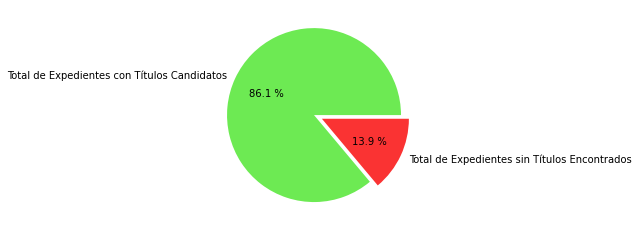

In [33]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

totalExp = len(dfSinTitulosEncontrados)
totalExpSinEncontrar = len(dfExpSinTitulosEncontrados)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalExp, totalExpSinEncontrar]
nombreTitulos = ['Total de Expedientes con Títulos Candidatos', 'Total de Expedientes sin Títulos Encontrados']
colores = ['#6DEA53','#FA3333']
desfase=(0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

### Títulos con números romanos en minusculas. Escritos en mayusculas y minusculas.

In [34]:
# Busca títulos en mayusculas o minusculas que comienzan con numeros romanos en minuscula.
def buscarTitulosRomanosMinusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(i{1,3}|iv|v|vi{1,3}|ix|x)[.)-]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 5:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())
            #i=i+1

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosRomanosMinusculas=[]
for expediente in dfSinTitulosEncontrados['expediente']:
    if len(buscarTitulosRomanosMinusculas(expediente)) > 3:
        titulosRomanosMinusculas.append(buscarTitulosRomanosMinusculas(expediente))

In [35]:
dfTitulosMayusculas.to_excel('titulos_mayusculas.xlsx', index=False)

# Expedientes con titulos en mayusculas, con titulos candidatos, sin titulos encontrados. Total de expedientes

In [36]:
print(f'''
Cantidad de expedientes que no son pericias médicas:             {len(dfNoPericiasMedicas)}
Cantidad de expedientes que tienen títulos en mayúsculas:        {len(dfTitulosMayusculas)}
Cantidad de expedientes que tienen títulos candidatos:           {len(dfExpTitulosCandidatos)}
Cantidad de expedientes que no tienen títulos localizados:       {len(dfExpSinTitulosEncontrados)}  
Total de expedientes:                                            {len(df)} ''')


Cantidad de expedientes que no son pericias médicas:             615
Cantidad de expedientes que tienen títulos en mayúsculas:        1184
Cantidad de expedientes que tienen títulos candidatos:           1683
Cantidad de expedientes que no tienen títulos localizados:       324  
Total de expedientes:                                            3806 


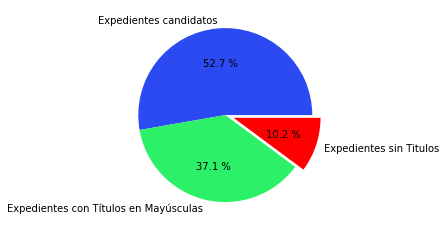

In [38]:
# Creo un grafico de torta expedientes por tipo de busqueda.
import matplotlib.pyplot as plt

totalCandidatos = len(dfExpTitulosCandidatos)
totalExpMayusculas = len(dfTitulosMayusculas)
totalSinTitulos = len(dfExpSinTitulosEncontrados)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalCandidatos, totalExpMayusculas, totalSinTitulos]
nombreTitulos = ['Expedientes candidatos', 'Expedientes con Títulos en Mayúsculas', 'Expedientes sin Titulos']
colores = ['#2C4AF1','#2CF168', 'r']
desfase=(0,0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

# TÍTULOS ENCONTRADOS Y UBICACIÓN

In [39]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion=[]

for titulo in titulosMayusculas[0]:
    inicioTitulo = dfLimpio[0].index(titulo)
    palabrasPorTitulo = len(titulo)
    finalTitulo = inicioTitulo + palabrasPorTitulo
    titulosPosicion.append((titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

pprint(titulosPosicion)

[('I-PROEMIO:', 161, 171, 10),
 ('II-ANTECEDENTES DE INTERES MEDICO-LEGAL:', 690, 730, 40),
 ('III-EXAMEN FISICO DEL ACTOR:', 1646, 1674, 28),
 ('IV-CONSIDERACIONES MEDICO-LEGALES:', 9140, 9174, 34),
 ('VII-CONCLUSIONES.', 19171, 19188, 17),
 ('VII-INCAPACIDAD:', 20974, 20990, 16),
 ('VIII CONTESTACION DE LOS PUNTOS DE PERICIA:', 21297, 21340, 43),
 ('IX-PETITORIO:', 21411, 21424, 13)]


In [40]:
# Creo una variable que contiene el párrafo de un título en particular
parrafoConsideraciones = dfLimpio[0][171:690]
#parrafoConsideraciones = general(parrafoConsideraciones)
parrafoConsideraciones = remove_stops(parrafoConsideraciones)
parrafoConsideraciones = limpiar_palabras(parrafoConsideraciones)
pprint(parrafoConsideraciones)
pprint(f'LONGITUD DE PALABRAS: {len(parrafoConsideraciones.split())}')

('juez nacional hortas maria andrea perito medico oficio siguientes autos '
 'domicilio constituido calle austria piso dpto capital domicilio electronico '
 'cumplimiento dispuesto referente presentes autos despues haber examinado '
 'dijo boiero franco ivan tomaron momento examen clinico actual consideraron '
 'capacidad generica particular puntos pericia solicitados partes')
'LONGITUD DE PALABRAS: 44'


# DATAFRAME DE UBICACIÓN DE TÍTULOS ENCONTRADOS

In [41]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion1=[]
expedientesRaros = []
tipo='encontrado'
for i in range(len(dfLimpio)):
    for titulo in titulosMayusculas[i]:
        inicioTitulo = dfLimpio[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[\n\.):-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        #if palabrasPorTitulo > 0:
        titulosPosicion1.append((i, tipo, titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))
        #else:
         
        #   expedientesRaros.append((i, str(dfLimpio[i])))

dfUbicacionTitulos = pd.DataFrame(titulosPosicion1,columns=['ide','tipo','titulo','inicio','fin','longitud'])

# BORRAR PALABRAS QUE NO SON TÍTULOS

In [42]:
dfUbicacionTitulos = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['titulo'] ==''].index)
#Aplicando esto, de 5671 filas, se reduce a 5286. 

## Calculo de la longitud de los párrafos

In [46]:
dfUbicacionTitulos.reset_index(drop=True, inplace=True)

In [47]:
# Calculo la longitud de caracteres de parrafos
def longitud_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['inicio'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['ide'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                parrafo = remove_stops(parrafo)
                parrafo = general(parrafo)
               
                #parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                parrafo = general(parrafo)
                parrafo = remove_stops(parrafo)
                parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
        else:
            inicio = ubicacion['inicio'][i]
            idDf = ubicacion['ide'][i]
            parrafo = original[idDf][inicio:]
            parrafo = general(parrafo)
            parrafo = remove_stops(parrafo)
            parrafo = limpiar_palabras(parrafo)
            caracteres = len(parrafo.split())
            parrafos.append(caracteres)
    return parrafos

longitudP = longitud_parrafos(dfUbicacionTitulos, dfLimpio)

In [48]:
dfUbicacionTitulos['longitud_parrafo'] = pd.DataFrame(longitudP)

### Creo los dataframes con la ubicación de los títulos encontrados

In [49]:
dfUbicacionTitulos['titulo'].to_csv('titulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_csv('df_TitulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_excel('df_TitulosEncontrados.xlsx',index=False)

### Creo los dataframes con la ubicación de los títulos candidatos

In [50]:
dfUbicacionTitulosCandidatos.to_csv('df_titulosCandidatos.csv',index=False)
dfUbicacionTitulosCandidatos.to_excel('df_titulosCandidatos.xlsx', index=False)
dfUbicacionTitulosCandidatos['titulo'].to_csv('titulosCandidatos.csv',index=False)

In [51]:
dfUbicacionTitulos['longitud'].describe()

count    5286.000000
mean        2.418842
std         1.256708
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: longitud, dtype: float64

In [53]:
# Limpieza de parrafos
# Creo una lista de parrafos
def extraer_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['fin'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['ide'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split(sep=' ')
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split(sep=' ')
                parrafos.append(caracteres)
    return parrafos

parrafos = extraer_parrafos(dfUbicacionTitulos,dfLimpio)

In [55]:
print(f'LONGITUD DE PALABRAS: {len(parrafos[0])}')

LONGITUD DE PALABRAS: 44


# CREACION DE DOCUMENTO HTML
## MUESTRO LOS TITULOS Y PARRAFOS ENCONTRADOS

In [58]:
# Creamos un dataframe para colocar el salto de linea en formato HTML
dfLimpioHTML = dfLimpio.apply(str)
def limpiarTextoHTML(text):
    text = text.strip().replace('\n','<br>')
    return text

dfLimpioHTML = dfLimpioHTML.apply(limpiarTextoHTML)
parrafoConsideraciones = limpiarTextoHTML(parrafoConsideraciones)

In [59]:
colors = {
    'procedimientos': '#cd5c5c',
    'cuerpos': '#99ccff',
    'afecciones': '#ffa500'
}

body = f'''
        <p>
        {dfLimpioHTML[1]}
        </p>
        <br>
        '''
body = body.replace(parrafoConsideraciones,f'<span style="background-color: #99ccff">{parrafoConsideraciones}</span>')
for titulo in titulosMayusculas[1]:
    body = body.replace(titulo,f'<span style="background-color: #cd5c5c">{titulo}</span>')
with open('parrafos.html','w', encoding="utf-8") as f:
    f.write(body)

# Gráfico de frecuencia de palabras por párrafo. Histograma.

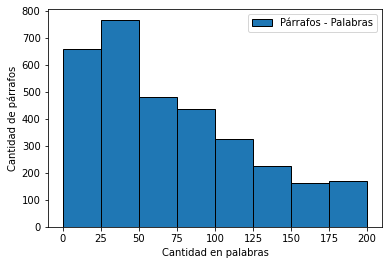

In [60]:
import matplotlib.pyplot as plt

longParrafos = dfUbicacionTitulos['longitud_parrafo']
bins1 = [0, 25, 50, 75, 100, 125, 150, 175, 200] #, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000

plt.hist(longParrafos, bins1, edgecolor='black', label='Párrafos - Palabras')
plt.xlabel('Cantidad en palabras')
plt.ylabel('Cantidad de párrafos')
plt.legend()
plt.show()

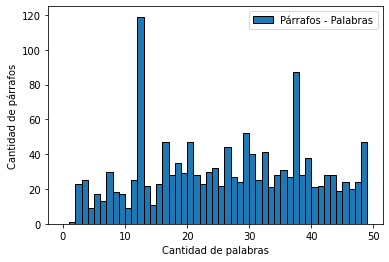

In [61]:
import matplotlib.pyplot as plt

longParrafos = dfUbicacionTitulos['longitud_parrafo']
#bins2 = [0,50, 100,150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900,950, 1000]#[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] #, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000

plt.hist(longParrafos, bins=range(0,50,1),ec='k',label='Párrafos - Palabras', align='mid')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Cantidad de párrafos')
plt.legend()
#plt.axis([1,100,1,300])
plt.show()
# total de parrafos 5775
# limpiar titulos con parrafos de menos de 10 palabras.

# Gráfico de frecuencia de palabras por párrafo. BoxPlot.

In [63]:
# Elimino titulos en blanco y de longitud de parrafos mayores a 800 palabras para poder mejorar el grafico
dfUbicacionTitulosLimpio = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['titulo'] ==''].index)
dfUbicacionTitulosLimpio = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['longitud_parrafo'] > 800].index)
longParrafosBox = dfUbicacionTitulosLimpio['longitud_parrafo']

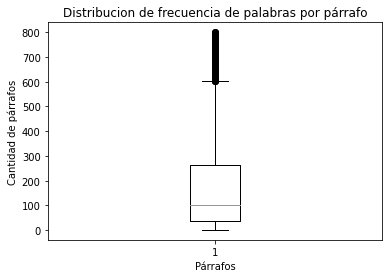

In [64]:
# BoxPlot de distribucion de palabras por parrafos.
plt.boxplot(longParrafosBox)
plt.title('Distribucion de frecuencia de palabras por párrafo')
plt.xlabel('Párrafos')
plt.ylabel('Cantidad de párrafos')
plt.show()

In [65]:
longParrafosBox.describe()

count    4717.000000
mean      181.308035
std       191.736279
min         1.000000
25%        39.000000
50%       100.000000
75%       264.000000
max       800.000000
Name: longitud_parrafo, dtype: float64

# TF-IDF

In [68]:
import numpy as np
import pandas as pd
import nltk
import re
from sklearn import feature_extraction

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=30,
                                 min_df=100,
                                 use_idf=True, ngram_range=(1,4))# tokenizer=tokenize_and_stem

tfidf_matrix = tfidf_vectorizer.fit(dfUbicacionTitulos['titulo']) #fit the vectorizer to synopses
tfidf_final_candidato = tfidf_matrix.transform(dfUbicacionTitulosCandidatos['titulo'])
tfidf_final_encontrado = tfidf_matrix.transform(dfUbicacionTitulos['titulo'])
print(tfidf_final_encontrado.shape)

(5286, 30)


## CountVectorizer

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

coun_vect = CountVectorizer(max_df=0.99, min_df=100, max_features=30)
count_matrix = coun_vect.fit(dfUbicacionTitulos['titulo'])
count_final_candidato = count_matrix.transform(dfUbicacionTitulosCandidatos['titulo'])
count_final_encontrado = count_matrix.transform(dfUbicacionTitulos['titulo'])
count_array = count_final_candidato.toarray()


# PRUEBAS

In [79]:
# Se unen los dos dataframes en uno solo: Guardo los titulos encontrados y titulos candidatos en un solo dataframe
dfTitulos = pd.concat([dfUbicacionTitulos, dfUbicacionTitulosCandidatos], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
dfTitulos = dfTitulos[['ide', 'tipo', 'titulo', 'inicio', 'fin', 'longitud']]
dfTitulos.columns = ['ide', 'tipo', 'titulo', 'inicio', 'fin', 'longitud']

In [80]:
# Guardo los titulos encontrados y titulos candidatos en un solo dataframe y lo convierot a un archivo .csv
dfTitulos.to_csv('dftitulos.csv',index=False)

In [81]:
def limpiar_tokenizar(text):
    tokenizado=[]
    for titulo in text:
        # Tokenización por palabras individuales
        tokenizado.append(titulo.split(sep = ' '))
    return(tokenizado)

In [82]:
dfTitulos['titulo_tokenizado'] = limpiar_tokenizar(dfTitulos['titulo'])
dfTitulos[['titulo', 'titulo_tokenizado']].head()

,titulo,titulo_tokenizado
0,proemio,[proemio]
1,antecedentes interes medico legal,"[antecedentes, interes, medico, legal]"
2,examen fisico actor,"[examen, fisico, actor]"
3,consideraciones medico legales,"[consideraciones, medico, legales]"
4,conclusiones,[conclusiones]


In [83]:
# Unnest de la columna titulo_tokenizado
# ==============================================================================
titulos_tidy = dfTitulos.explode(column='titulo_tokenizado')
titulos_tidy = titulos_tidy.drop(columns='titulo')
titulos_tidy = titulos_tidy.drop(columns='longitud')
titulos_tidy = titulos_tidy.rename(columns={'titulo_tokenizado':'token'})
titulos_tidy = titulos_tidy.drop(titulos_tidy[titulos_tidy['token'] ==''].index)
titulos_tidy.head(3)

,ide,tipo,inicio,fin,token
0,0,encontrado,161,171,proemio
1,0,encontrado,690,730,antecedentes
1,0,encontrado,690,730,interes


In [84]:
#titulos_tidy.reset_index(drop=True, inplace=True)

## Frecuencia de título

In [85]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por títulos')
print('--------------------------')
titulos_tidy.groupby(by='tipo')['token'].count()

--------------------------
Palabras totales por títulos
--------------------------


tipo
candidato     24734
encontrado    12786
Name: token, dtype: int64

In [86]:
# Palabras distintas por títulos
# ==============================================================================
print('----------------------------')
print('Palabras distintas por títulos')
print('----------------------------')
titulos_tidy.groupby(by='tipo')['token'].nunique()

----------------------------
Palabras distintas por títulos
----------------------------


tipo
candidato     3613
encontrado    1026
Name: token, dtype: int64

In [87]:
# Longitud media y desviación de los titulos de cada tipo
# ==============================================================================
temp_df = pd.DataFrame(titulos_tidy.groupby(by = ["tipo", "ide"])["token"].count())
temp_df.reset_index().groupby("tipo")["token"].agg(['mean', 'std'])

,mean,std
tipo,,
candidato,14.900000,16.116353
encontrado,11.118261,8.571205


In [88]:
# Top 5 títulos más repetidos por tipo
# ==============================================================================
print('Top 5 títulos más repetidos por tipo')
titulos_tidy.groupby(['tipo','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('tipo') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

Top 5 títulos más repetidos por tipo


tipo             token  count
tipo                                                
candidato  1816   candidato           informe    551
           1368   candidato            examen    411
           2138   candidato            medico    395
           2768   candidato  psicodiagnostico    247
           649    candidato      conclusiones    243
encontrado 4204  encontrado            medico    827
           4421  encontrado            puntos    609
           3807  encontrado      conclusiones    576
           4329  encontrado           pericia    537
           3710  encontrado      antecedentes    485

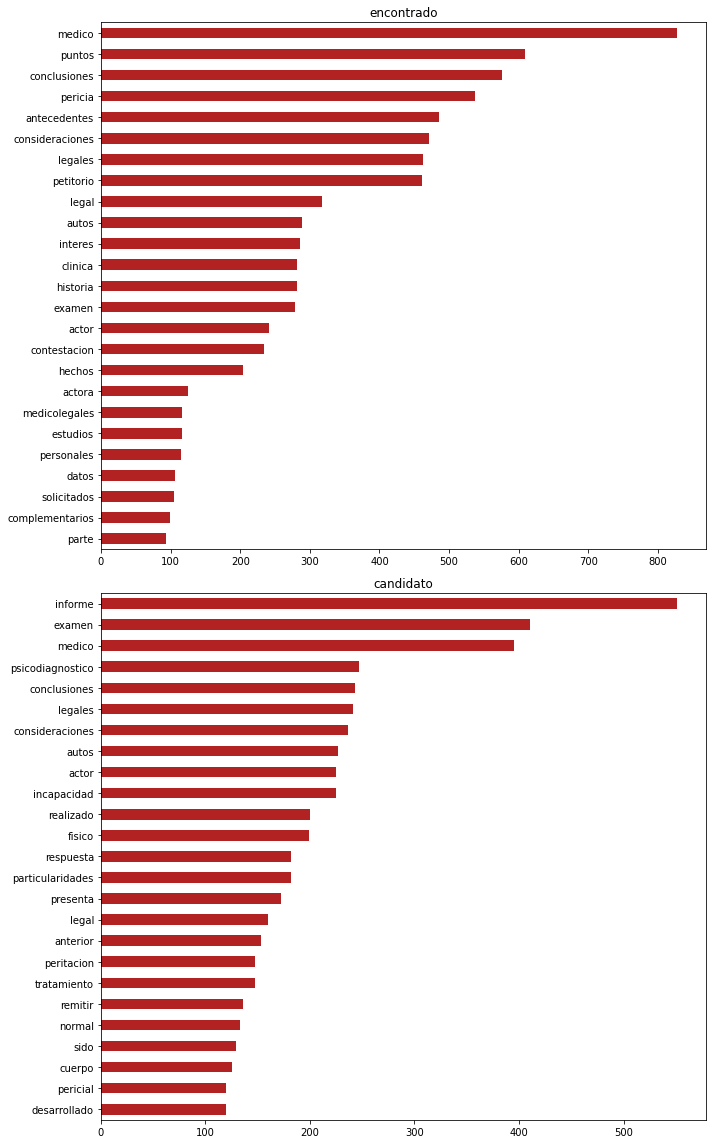

In [89]:
# Top 10 títulos por tipo 
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(10, 16))
for i, tipo in enumerate(titulos_tidy.tipo.unique()):
    df_temp = titulos_tidy[titulos_tidy.tipo == tipo]
    counts  = df_temp['token'].value_counts(ascending=False).head(25)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(tipo)

fig.tight_layout()

In [90]:
# Pivotado de títutlos por tipo y token.
# ==============================================================================
titulos_pivot = titulos_tidy.groupby(["tipo","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tipo", values= "count")
titulos_pivot.columns.name = None

In [93]:
# tokens mas frecuentes en ambos tipos de titulos: Encontrados-Candidatos
for i, count in enumerate(titulos_pivot.encontrado):
    if titulos_pivot.candidato[i] > 80 and count > 80:
        print(titulos_pivot.index[i])

actor
actora
antecedentes
autos
conclusiones
consideraciones
examen
hechos
incapacidad
interes
legal
legales
medico
pericia
puntos


In [94]:
# Test de correlación (coseno) por títulos candidato y título encontrado
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return distancia

matriz_corr = titulos_pivot.corr(method=similitud_coseno)

In [95]:
print('Correlación entre tipos de títulos')
matriz_corr

Correlación entre tipos de títulos


,candidato,encontrado
candidato,1.000000,0.400888
encontrado,0.400888,1.000000


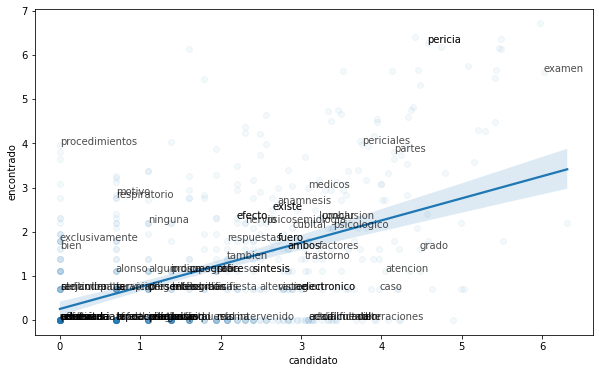

In [96]:
import seaborn as sns

# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(10, 6))
temp = titulos_pivot.dropna()
sns.regplot(
    x  = np.log(temp.candidato),
    y  = np.log(temp.encontrado),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.candidato[i]), np.log(temp.encontrado[i])),
        alpha = 0.7
    )

In [97]:
# Número de palabras comunes en títulos encotnrados y candidatos.
# ==============================================================================
titulo_encontrado = set(titulos_tidy[titulos_tidy.tipo == 'encontrado']['token'])
titulo_candidato = set(titulos_tidy[titulos_tidy.tipo == 'candidato']['token'])


print(f"Palabras comunes entre títulos encontrados y títulos candidatos: {len(titulo_encontrado.intersection(titulo_candidato))}")

Palabras comunes entre títulos encontrados y títulos candidatos: 578


In [98]:
# Cálculo del log of odds ratio de cada palabra títulos encontrados y títulos candidatos
# ==============================================================================
# Pivotaje y despivotaje
titulos_pivot = titulos_tidy.groupby(["tipo","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tipo", values= "count")

titulos_pivot = titulos_pivot.fillna(value=0)
titulos_pivot.columns.name = None

titulos_unpivot = titulos_pivot.melt(value_name='n', var_name='tipo', ignore_index=False)
titulos_unpivot = titulos_unpivot.reset_index()

# Selección de los títlos encontrados y candidatos. 
titulos_unpivot = titulos_unpivot[titulos_unpivot.tipo.isin(['encontrado', 'candidato'])]

# Se añade el total de palabras de cada titulo.
titulos_unpivot = titulos_unpivot.merge(
                    titulos_tidy.groupby('tipo')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'tipo'
                 )

# Cálculo de odds y log of odds de cada palabra
titulos_logOdds = titulos_unpivot.copy()
titulos_logOdds['odds'] = (titulos_logOdds.n + 1) / (titulos_logOdds.N + 1)
titulos_logOdds = titulos_logOdds[['token', 'tipo', 'odds']] \
                    .pivot(index='token', columns='tipo', values='odds')
titulos_logOdds.columns.name = None

titulos_logOdds['log_odds']     = np.log(titulos_logOdds.encontrado/titulos_logOdds.candidato)
titulos_logOdds['abs_log_odds'] = np.abs(titulos_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser título encontrado. Esto es así porque el ratio sea ha
# calculado como encontrado/candidato.
titulos_logOdds['tipo_frecuente'] = np.where(titulos_logOdds.log_odds > 0,
                                              "encontrado",
                                              "candidato"
                                    )

In [99]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadas en títulos encontrados y tíulos candidatos')
print('-----------------------------------')
titulos_logOdds.sort_values('abs_log_odds', ascending=False).head(30)

-----------------------------------
Top 10 palabras más diferenciadas en títulos encontrados y tíulos candidatos
-----------------------------------


,candidato,encontrado,log_odds,abs_log_odds,tipo_frecuente
token,,,,,
petitorio,0.000243,0.036130,5.003596,5.003596,encontrado
realizado,0.008126,0.000078,-4.643515,4.643515,candidato
integral,0.000040,0.004145,4.630082,4.630082,encontrado
problematica,0.000040,0.004067,4.611034,4.611034,encontrado
llevados,0.000040,0.003832,4.551611,4.551611,encontrado
particularidades,0.007398,0.000078,-4.549696,4.549696,candidato
cabo,0.000040,0.003754,4.530991,4.530991,encontrado
auxiliares,0.000040,0.003050,4.323352,4.323352,encontrado
remitir,0.005539,0.000078,-4.260191,4.260191,candidato


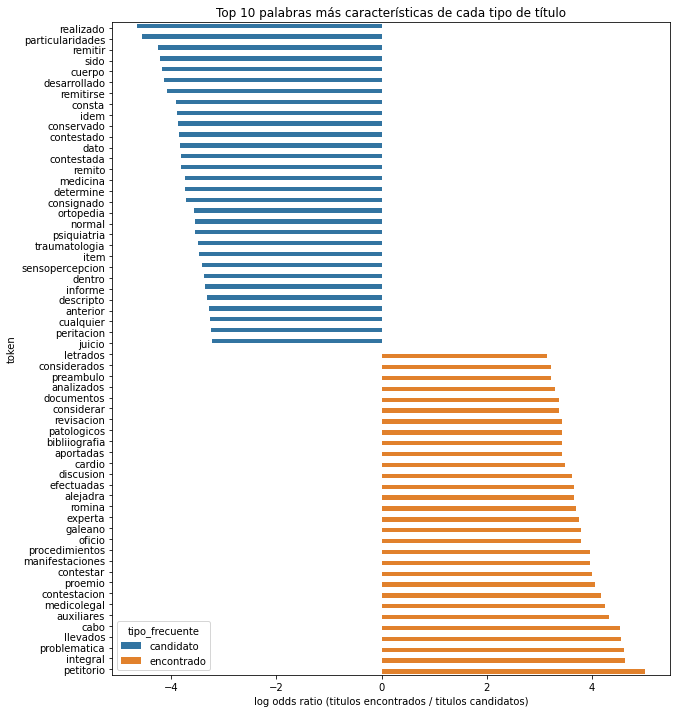

In [100]:
# Top 15 palabras más características de cada tipo de título
# ==============================================================================

top_30 = titulos_logOdds[['log_odds', 'abs_log_odds', 'tipo_frecuente']] \
        .groupby('tipo_frecuente') \
        .apply(lambda x: x.nlargest(30, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(10, 12))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'tipo_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 10 palabras más características de cada tipo de título')
ax.set_xlabel('log odds ratio (titulos encontrados / titulos candidatos)');

In [105]:
print(dfSinTitulosEncontrados.expediente[0][15874:])

ponderacion establecidos decreto 96. Ver conclusiones medico legales. 8) Puntos pericia parte demandada ASPECTO FISICO 1) Historia Clinica actor expresa mencion capitulo Estado Actual secuelas objetivas pudiera presentar. Del examen fisico relato actor constancias autos. 2) Indique si examenes semiologicos respectivos revelan patologias trastornos incapacidad algun tipo. No presenta secuelas posteriores meniscectomia. 3) Indique expresion fundamentos literatura cientifica funda causa correspondiera atribuir cualquier limitacion pudiera advertir actor. Aclarara asimismo epoca generacion consolidacion mismas. Ver consideraciones conclusiones medico legales. 4) Si actor padece disminucion capacidad fisica consecuencia exclusiva accidente discriminando pudiera presentar atribuibles origen indicando caso grado incapacidad hubiere detectado tal 1 motivo epoca consolidacion mismas. En punto indague expresamente actor contingencias anteriores. La incapacidad originada accidente guarda relacion

In [106]:
dfSinTitulosEncontrados.expediente[2000][11877:]

'4.Conclusiones Medicolegales. Vistos antecedentes obrantes autos cuanto surge acabado examen clinico semiologico efectuado persona actor demuestran estudios complementarios diagnostico fecha presenta incapacidad orden 5420 total permanente guarda relacion estricta causalidad evento dañoso autos segun Baremo Ley  habiendose aportado autos documental medica alguna permita sostener contrario. 5.Acompaña copias digitales. En cumplimiento dispuesto Acordada CSJN experto manifiesta manera simultanea presentacion presente informe procedido acompañar referidas copias digitales. Solicito agreguen referidas copias digitales efectos. Es cuanto puedo informar VS. Proveer Conformidad SERA JUSTICIA. Dr. Guillermo Ricardo Dambrosi MN 45.57 PERITO MEDICO'

In [107]:
print(f'''Títulos Encontrados: {len(dfUbicacionTitulos)}
Títulos Candidatos: {len(dfUbicacionTitulosCandidatos)}
''')

Títulos Encontrados: 5286
Títulos Candidatos: 10370

